# Iris Classifier Tensorflow et Exportation Android

Le notebook présente comment entrainer et utiliser un réseau de neurone, entrainé sur la base de donnée des Iris fournie par Tensorflow.
Il présente également une méthode pour exporter le modèle du réseau de neurone (en .pb) afin de l'utiliser dans une aplication android. Pour avoir l'explication des codes, vous pouvez lire les guides en lignes.

# Chargement des librairies

In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

import numpy as np
import pandas as pd

import csv

print("TensorFlow version: {}".format(tf.VERSION))

Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow version: 1.7.0


# Récupération des données

In [2]:
def split_data(data):
#Fonction qui permet de séparer un tableau de données en features et en labels    
    print("La taille des données est ",Train_Iris_Data.shape)
    print(data)
    data=np.array(data)
    #print(Train_Iris_Data)

    features = data[:,:-1]
    labels = data[:,-1:]
    labels = labels.reshape((-1,))

    return features,labels

#L'url où sont contenue les données de fleurs
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
#Téléchargement des données
Train_Iris_Data = pd.read_csv(train_dataset_url)
#Séparation en features et en label
features, labels = split_data(Train_Iris_Data)
print(features)
print(labels)

#L'url où sont contenue les données de test
test_url = "http://download.tensorflow.org/data/iris_test.csv"
#Téléchargement des données de test
Test_Iris_Data = pd.read_csv(test_url)
#Séparation en features et en label
features_test, labels_test = split_data(Test_Iris_Data)

La taille des données est  (120, 5)
     120    4  setosa  versicolor  virginica
0    6.4  2.8     5.6         2.2          2
1    5.0  2.3     3.3         1.0          1
2    4.9  2.5     4.5         1.7          2
3    4.9  3.1     1.5         0.1          0
4    5.7  3.8     1.7         0.3          0
5    4.4  3.2     1.3         0.2          0
6    5.4  3.4     1.5         0.4          0
7    6.9  3.1     5.1         2.3          2
8    6.7  3.1     4.4         1.4          1
9    5.1  3.7     1.5         0.4          0
10   5.2  2.7     3.9         1.4          1
11   6.9  3.1     4.9         1.5          1
12   5.8  4.0     1.2         0.2          0
13   5.4  3.9     1.7         0.4          0
14   7.7  3.8     6.7         2.2          2
15   6.3  3.3     4.7         1.6          1
16   6.8  3.2     5.9         2.3          2
17   7.6  3.0     6.6         2.1          2
18   6.4  3.2     5.3         2.3          2
19   5.7  4.4     1.5         0.4          0
20   6.7  3.3     5

In [3]:
# Exemple d'une seule donnée
print("example features:", features[0])
print("example label:", labels[0])

example features: [ 6.4  2.8  5.6  2.2]
example label: 2.0


# Création du modèle de réseau de neurone

In [4]:
# Initialiser les placeholders
x = tf.placeholder(dtype = tf.float32, shape = [None, 4], name = "input")
y = tf.placeholder(dtype = tf.int32, shape = [None], name="label")

#Fonction pour une couche relu
def add_dense_hidden_layer_op(x, num_neurons_previous_layer, num_neurons_current_layer, name_scope="relu"):
    with tf.name_scope(name_scope):
        # Model parameters
        weights = tf.Variable(tf.truncated_normal(shape=[num_neurons_previous_layer, num_neurons_current_layer], stddev=0.1, name="weights"))
        biases = tf.Variable(tf.zeros([num_neurons_current_layer]), name="biases")
        # Activation function
        relu = tf.nn.relu(tf.matmul(x, weights) + biases, name="relu")
        # TensorBoard Summary
        tf.summary.histogram(relu.op.name + '/activations', relu)  
        return relu

# Fonction pour une couche Softmax
def add_softmax_op(x, num_neurons_previous_layer, num_classes, name_scope="softmax"):
    with tf.name_scope(name_scope):
        # Model parameters
        weights = tf.Variable(tf.zeros([num_neurons_previous_layer, num_classes]),name="weight")
        biases = tf.Variable(tf.zeros([num_classes]),name="biases")
        # Logits and softmax layer
        logits = tf.matmul(x, weights) + biases
        softmax = tf.nn.softmax(logits, name = "final_result")
        # TensorBoard Summary
        tf.summary.histogram(softmax.op.name + '/activations', softmax)
        return softmax, logits

#Fabrication du réseau de neurone
dense = add_dense_hidden_layer_op(x=x, num_neurons_previous_layer=4, num_neurons_current_layer=10, name_scope="dense")
dense2 = add_dense_hidden_layer_op(x=dense, num_neurons_previous_layer=10, num_neurons_current_layer=10, name_scope="dense2")
softmax, logits = add_softmax_op(x=dense2, num_neurons_previous_layer=10, num_classes=3, name_scope="softmax")


with tf.name_scope("Loss"):
    # Calcul de la fonction de coût
    loss = tf.reduce_mean( tf.nn.sparse_softmax_cross_entropy_with_logits (labels = y, 
                                                                    logits = logits,name="cross_entropy"))
    # Pour afficher dans tensorBoard
    tf.summary.histogram(loss.op.name, loss)
    
with tf.name_scope("Train"):
    # La fonction d'optimisation
    train_op = tf.train.GradientDescentOptimizer(learning_rate= 0.005).minimize(loss)
    
with tf.name_scope("accuracy"):
    # Trouve l'indice de la sortie la plus élevée, donc le label prédit
    pred = tf.argmax(softmax, 1, name = "out")
    # Calcul le taux de prédiction correct
    correct_prediction = tf.equal(tf.cast(pred, tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# L'opérateur qui permet d'afficher les variables dans TensorBoard
merged = tf.summary.merge_all()
# L'opérateur qui permet de sauvegarder le modèle
saver = tf.train.Saver()

# Entrainement du modèle

 Epoch : 0  Loss:  1.0986  Accuracy:  0.691667 Accuracy Test:  0.533333
 Epoch : 10  Loss:  1.09845  Accuracy:  0.691667 Accuracy Test:  0.533333
 Epoch : 20  Loss:  1.09831  Accuracy:  0.691667 Accuracy Test:  0.533333
 Epoch : 30  Loss:  1.09816  Accuracy:  0.691667 Accuracy Test:  0.533333
 Epoch : 40  Loss:  1.09802  Accuracy:  0.691667 Accuracy Test:  0.533333
 Epoch : 50  Loss:  1.09789  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 60  Loss:  1.09775  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 70  Loss:  1.09762  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 80  Loss:  1.09748  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 90  Loss:  1.09735  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 100  Loss:  1.09722  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 110  Loss:  1.09709  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 120  Loss:  1.09696  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 130  Loss:  1.09683  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch 

 Epoch : 1180  Loss:  0.963417  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1190  Loss:  0.956582  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1200  Loss:  0.949407  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1210  Loss:  0.94188  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1220  Loss:  0.934003  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1230  Loss:  0.925772  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1240  Loss:  0.917178  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1250  Loss:  0.908232  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1260  Loss:  0.898949  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1270  Loss:  0.889332  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1280  Loss:  0.879386  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1290  Loss:  0.869125  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1300  Loss:  0.858567  Accuracy:  0.7 Accuracy Test:  0.533333
 Epoch : 1310  Loss:  0.847729  Accuracy:  0.7 Accuracy Test:  0.

 Epoch : 2360  Loss:  0.273607  Accuracy:  0.95 Accuracy Test:  0.966667
 Epoch : 2370  Loss:  0.271086  Accuracy:  0.95 Accuracy Test:  0.966667
 Epoch : 2380  Loss:  0.268582  Accuracy:  0.95 Accuracy Test:  0.966667
 Epoch : 2390  Loss:  0.266096  Accuracy:  0.958333 Accuracy Test:  0.966667
 Epoch : 2400  Loss:  0.263627  Accuracy:  0.958333 Accuracy Test:  0.966667
 Epoch : 2410  Loss:  0.261178  Accuracy:  0.958333 Accuracy Test:  0.966667
 Epoch : 2420  Loss:  0.258749  Accuracy:  0.958333 Accuracy Test:  0.966667
 Epoch : 2430  Loss:  0.256338  Accuracy:  0.966667 Accuracy Test:  0.966667
 Epoch : 2440  Loss:  0.253947  Accuracy:  0.966667 Accuracy Test:  0.966667
 Epoch : 2450  Loss:  0.251577  Accuracy:  0.966667 Accuracy Test:  0.966667
 Epoch : 2460  Loss:  0.249227  Accuracy:  0.966667 Accuracy Test:  0.966667
 Epoch : 2470  Loss:  0.246899  Accuracy:  0.966667 Accuracy Test:  0.966667
 Epoch : 2480  Loss:  0.244592  Accuracy:  0.966667 Accuracy Test:  0.966667
 Epoch : 24

 Epoch : 3500  Loss:  0.118811  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3510  Loss:  0.118295  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3520  Loss:  0.117786  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3530  Loss:  0.117284  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3540  Loss:  0.116789  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3550  Loss:  0.116301  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3560  Loss:  0.115819  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3570  Loss:  0.115344  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3580  Loss:  0.114875  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3590  Loss:  0.114412  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3600  Loss:  0.113956  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3610  Loss:  0.113506  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 3620  Loss:  0.113061  Accuracy:  0.983333 Accuracy Test:  0.966667

 Epoch : 4670  Loss:  0.0861581  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4680  Loss:  0.0860123  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4690  Loss:  0.0858676  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4700  Loss:  0.0857241  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4710  Loss:  0.0855818  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4720  Loss:  0.0854407  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4730  Loss:  0.0853007  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4740  Loss:  0.0851618  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4750  Loss:  0.0850239  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4760  Loss:  0.0848873  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4770  Loss:  0.0847517  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4780  Loss:  0.0846172  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 4790  Loss:  0.0844837  Accuracy:  0.983333 Accuracy Te

 Epoch : 5810  Loss:  0.0747951  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5820  Loss:  0.0747272  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5830  Loss:  0.0746596  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5840  Loss:  0.0745924  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5850  Loss:  0.0745256  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5860  Loss:  0.0744591  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5870  Loss:  0.074393  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5880  Loss:  0.0743272  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5890  Loss:  0.0742618  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5900  Loss:  0.0741967  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5910  Loss:  0.074132  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5920  Loss:  0.0740676  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 5930  Loss:  0.0740035  Accuracy:  0.983333 Accuracy Test

 Epoch : 6890  Loss:  0.069086  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6900  Loss:  0.0690448  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6910  Loss:  0.0690037  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6920  Loss:  0.0689628  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6930  Loss:  0.0689221  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6940  Loss:  0.0688816  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6950  Loss:  0.0688412  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6960  Loss:  0.0688009  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6970  Loss:  0.0687608  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6980  Loss:  0.0687209  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 6990  Loss:  0.0686811  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 7000  Loss:  0.0686415  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 7010  Loss:  0.068602  Accuracy:  0.983333 Accuracy Test

 Epoch : 7960  Loss:  0.0654193  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 7970  Loss:  0.0653907  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 7980  Loss:  0.0653622  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 7990  Loss:  0.0653338  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8000  Loss:  0.0653054  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8010  Loss:  0.0652772  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8020  Loss:  0.065249  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8030  Loss:  0.0652209  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8040  Loss:  0.0651929  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8050  Loss:  0.065165  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8060  Loss:  0.0651371  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8070  Loss:  0.0651093  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 8080  Loss:  0.0650816  Accuracy:  0.983333 Accuracy Test

 Epoch : 9050  Loss:  0.0627169  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9060  Loss:  0.0626953  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9070  Loss:  0.0626738  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9080  Loss:  0.0626523  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9090  Loss:  0.0626309  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9100  Loss:  0.0626095  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9110  Loss:  0.0625881  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9120  Loss:  0.0625668  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9130  Loss:  0.0625456  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9140  Loss:  0.0625244  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9150  Loss:  0.0625032  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9160  Loss:  0.0624822  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 9170  Loss:  0.0624611  Accuracy:  0.983333 Accuracy Te

 Epoch : 10200  Loss:  0.0605041  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10210  Loss:  0.0604869  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10220  Loss:  0.0604697  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10230  Loss:  0.0604525  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10240  Loss:  0.0604354  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10250  Loss:  0.0604183  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10260  Loss:  0.0604012  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10270  Loss:  0.0603841  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10280  Loss:  0.060367  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10290  Loss:  0.0603501  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10300  Loss:  0.0603331  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10310  Loss:  0.0603162  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 10320  Loss:  0.0602992  Accuracy:  0.983333

 Epoch : 11320  Loss:  0.0587323  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11330  Loss:  0.0587178  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11340  Loss:  0.0587032  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11350  Loss:  0.0586887  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11360  Loss:  0.0586742  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11370  Loss:  0.0586597  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11380  Loss:  0.0586452  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11390  Loss:  0.0586307  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11400  Loss:  0.0586163  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11410  Loss:  0.0586018  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11420  Loss:  0.0585874  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11430  Loss:  0.0585731  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 11440  Loss:  0.0585587  Accuracy:  0.98333

 Epoch : 12450  Loss:  0.0571926  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12460  Loss:  0.0571799  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12470  Loss:  0.0571671  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12480  Loss:  0.0571543  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12490  Loss:  0.0571416  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12500  Loss:  0.0571289  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12510  Loss:  0.0571162  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12520  Loss:  0.0571034  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12530  Loss:  0.0570908  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12540  Loss:  0.0570781  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12550  Loss:  0.0570655  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12560  Loss:  0.0570528  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 12570  Loss:  0.0570402  Accuracy:  0.98333

 Epoch : 13510  Loss:  0.0559051  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13520  Loss:  0.0558935  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13530  Loss:  0.0558819  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13540  Loss:  0.0558704  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13550  Loss:  0.0558589  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13560  Loss:  0.0558473  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13570  Loss:  0.0558358  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13580  Loss:  0.0558243  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13590  Loss:  0.0558128  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13600  Loss:  0.0558013  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13610  Loss:  0.0557898  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13620  Loss:  0.0557783  Accuracy:  0.983333 Accuracy Test:  0.933333
 Epoch : 13630  Loss:  0.0557669  Accuracy:  0.98333

 Epoch : 14590  Loss:  0.0547068  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14600  Loss:  0.0546961  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14610  Loss:  0.0546855  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14620  Loss:  0.0546749  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14630  Loss:  0.0546643  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14640  Loss:  0.0546536  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14650  Loss:  0.054643  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14660  Loss:  0.0546324  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14670  Loss:  0.0546218  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14680  Loss:  0.0546112  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14690  Loss:  0.0546006  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14700  Loss:  0.05459  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 14710  Loss:  0.0545794  Accuracy:  0.983333 A

 Epoch : 15650  Loss:  0.0536159  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15660  Loss:  0.0536059  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15670  Loss:  0.0535959  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15680  Loss:  0.053586  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15690  Loss:  0.0535761  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15700  Loss:  0.0535661  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15710  Loss:  0.0535562  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15720  Loss:  0.0535464  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15730  Loss:  0.0535364  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15740  Loss:  0.0535265  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15750  Loss:  0.0535166  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15760  Loss:  0.0535067  Accuracy:  0.983333 Accuracy Test:  0.966667
 Epoch : 15770  Loss:  0.0534968  Accuracy:  0.983333

 Epoch : 16760  Loss:  0.0525452  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16770  Loss:  0.0525359  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16780  Loss:  0.0525265  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16790  Loss:  0.0525171  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16800  Loss:  0.0525078  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16810  Loss:  0.0524984  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16820  Loss:  0.0524891  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16830  Loss:  0.0524798  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16840  Loss:  0.0524705  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16850  Loss:  0.0524611  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16860  Loss:  0.0524518  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16870  Loss:  0.0524425  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 16880  Loss:  0.0524332  Accuracy:  0.99166

 Epoch : 17860  Loss:  0.0515428  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17870  Loss:  0.0515339  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17880  Loss:  0.051525  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17890  Loss:  0.0515162  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17900  Loss:  0.0515073  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17910  Loss:  0.0514984  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17920  Loss:  0.0514895  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17930  Loss:  0.0514807  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17940  Loss:  0.0514719  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17950  Loss:  0.051463  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17960  Loss:  0.0514542  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17970  Loss:  0.0514454  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 17980  Loss:  0.0514365  Accuracy:  0.991667 

 Epoch : 19020  Loss:  0.0505385  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19030  Loss:  0.0505301  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19040  Loss:  0.0505216  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19050  Loss:  0.0505132  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19060  Loss:  0.0505048  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19070  Loss:  0.0504964  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19080  Loss:  0.0504879  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19090  Loss:  0.0504795  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19100  Loss:  0.0504711  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19110  Loss:  0.0504626  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19120  Loss:  0.0504542  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19130  Loss:  0.0504458  Accuracy:  0.991667 Accuracy Test:  0.966667
 Epoch : 19140  Loss:  0.0504374  Accuracy:  0.99166

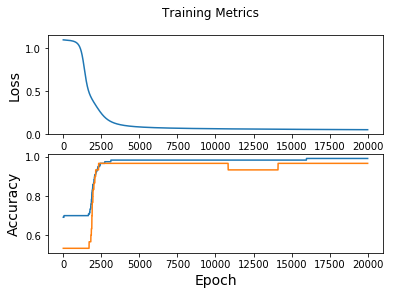

In [5]:
## Note: Rerunning this cell uses the same model variables
# Initialisation des liste qui contiennent l'évolution des métriques par boucle d'entrainement (afin d'afficher des courbes à la fin)
train_loss_results = []
train_accuracy_results = []
test_accuracy_results = []

# Ouverture de la Session TensorFlow
sess = tf.Session()
#Initialisation des variables du modèle
sess.run(tf.global_variables_initializer())
#Indique l'endroit où l'on veut le fichier TensorBoard
summary_writer = tf.summary.FileWriter("C:/Users/julie/Anaconda/Tensor_Flow/1. Iris Training", sess.graph)

#La boucle d'entrainement
for i in range(20000):
        # On appel l'opérateur d'entrainement
        sess.run(train_op, feed_dict={x: features, y: labels})
        # On appel les opérateurs des différentes métriques
        loss_val, summary, accuracy_val = sess.run([loss,merged,accuracy], feed_dict={x: features, y: labels})
        # On écrit les valeurs des variables de la boucle actuelle dans Tensorboard
        summary_writer.add_summary(summary, i)

        # On récupère le taux de prédiction sur les données test
        test_accuracy_val = sess.run([accuracy], feed_dict={x: features_test, y: labels_test})[0]
        
        #On ajoute les valeurs des métrriques de la boucle aux listes
        train_loss_results.append(loss_val)
        train_accuracy_results.append(accuracy_val)
        test_accuracy_results.append(test_accuracy_val)
        
        #On affiche les valeurs toutes les boucles multiple de 10
        if i % 10 == 0:
            print(" Epoch :", i," Loss: ", loss_val," Accuracy: ", accuracy_val,"Accuracy Test: ",test_accuracy_val)
            

# Affichage des tableaux qui récapitulent la variation des métriques durant l'entrainement
fig, axes = plt.subplots(2)
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
axes[1].plot(test_accuracy_results)
plt.show()

# Exportation du modèle pour l'utiliser sous Android

In [6]:
# Sauvegarde les variables du modèle sous forme de checkpoint (.ckpt)
saver.save(sess, './iris_model.ckpt')
# Sauvegarde le graphe du modèle sous forme de Graph_Def
tf.train.write_graph(sess.graph_def, ".", 'iris_model.pbtxt')

# Ce sont les nom et adresse, et valeurs que l'on vas utiliser dans les script d'optimisations du modèle
MODEL_NAME = 'iris_model'
input_graph_path = MODEL_NAME+'.pbtxt'
checkpoint_path = './'+MODEL_NAME+'.ckpt'
input_saver_def_path = ""
input_binary = False
output_node_names = "softmax/final_result"
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'
output_optimized_graph_name = 'optimized_'+MODEL_NAME+'.pb'
clear_devices = True

# Permet de geler le graphe, 
freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                         input_binary, checkpoint_path,output_node_names,
                         restore_op_name,filename_tensor_name,
                         output_frozen_graph_name,clear_devices,"")

# Ouvre et charge le fichier du modèle gelé
input_graph_def = tf.GraphDef()
with tf.gfile.Open(output_frozen_graph_name,"rb") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)

# Permet d'appliquer des optimisations au modèle
output_graph_def = optimize_for_inference_lib.optimize_for_inference(input_graph_def,
                                                                    ["input"],
                                                                    ["softmax/final_result"],
                                                                    tf.float32.as_datatype_enum)
# On écrit et on sauvegarde les modifications dans un nouveau fichier
f = tf.gfile.FastGFile(output_optimized_graph_name,"w")
f.write(output_graph_def.SerializeToString())



INFO:tensorflow:Restoring parameters from ./iris_model.ckpt
INFO:tensorflow:Froze 6 variables.
Converted 6 variables to const ops.


# Test

In [7]:
# Pour afficher le test final, on procède la même facons que précédemment
test_accuracy_val = sess.run([accuracy], feed_dict={x: features_test, y:labels_test})[0]
print ("Test accuracy:", test_accuracy_val)

Test accuracy: 0.966667


# Prediction

Tenter de prédire des données non labelisée.

In [8]:
# Les noms des classes de fleurs
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

#Les données dont on ne connait pas le résultat
features_pred = np.array ([    
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]])

# Pour afficher les probabilité des sorties après le softmax
softmax_val = sess.run([softmax], feed_dict={x: features_pred})[0]
print("Softmax:" ,(softmax_val*100))
# Pour afficher les labels et les classes que le réseau à prédit.
predictions = sess.run([pred], feed_dict={x: features_pred})[0]
print (predictions)
for i in (predictions):
    print (class_ids[predictions[i]])


Softmax: [[  9.96443329e+01   3.55671465e-01   5.22223407e-17]
 [  4.20440361e-03   9.99039841e+01   9.18066129e-02]
 [  4.61160141e-08   1.38115263e+00   9.86188507e+01]]
[0 1 2]
Iris setosa
Iris versicolor
Iris virginica
